In [3]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## Generate Data

$p(x, y) = N(\mu_x = 0, \mu_y = 0, \sigma_x = 1, \sigma_y = 1, r = 0.5)$

$p(x_{obs}, y_{obs}|x, y) = N(\mu_x = x, \mu_y = y, \sigma_x = 1, \sigma_y = 1, r = 0)$

In [4]:
x, y = multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]]).rvs(1000).T

(-4.0, 4.0)

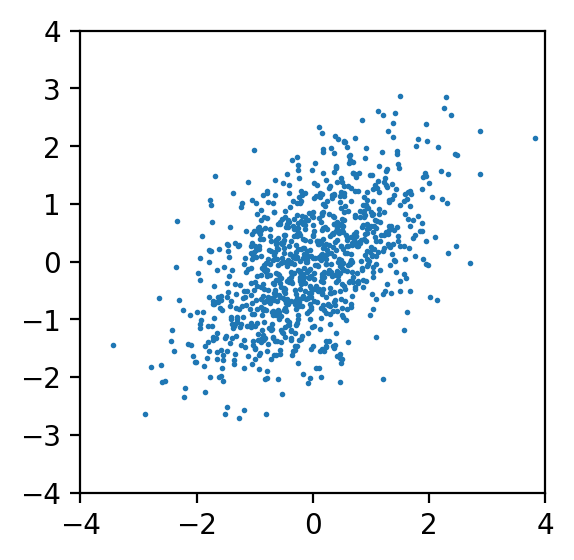

In [5]:
plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(x, y, s=1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [6]:
# estimate the mean and covariance of the data
mean = np.mean([x, y], axis=1)
cov = np.cov([x, y])
mean, cov

(array([-0.05656801, -0.02631514]),
 array([[1.02161416, 0.52784393],
        [0.52784393, 1.01452065]]))

In [7]:
# generate x_obs, y_obs
x_obs = np.zeros_like(x)
y_obs = np.zeros_like(y)
for i, (xi, yi) in enumerate(zip(x, y)):
    x_obs[i], y_obs[i] = multivariate_normal(mean=[xi, yi], cov=[[1, 0], [0, 1]]).rvs(1).T

(-5.0, 5.0)

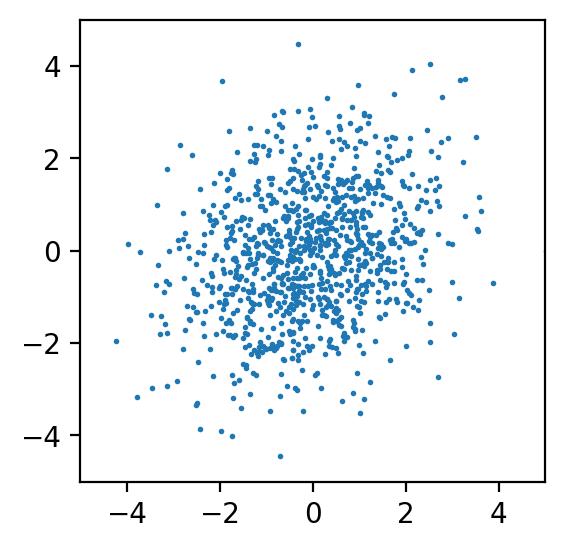

In [8]:
plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(x_obs, y_obs, s=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [9]:
mean = np.mean([x_obs, y_obs], axis=1)
cov = np.cov([x_obs, y_obs])
mean, cov

(array([-0.07090599, -0.05642744]),
 array([[1.95548545, 0.50459372],
        [0.50459372, 1.96445241]]))

## Inference

https://math.stackexchange.com/questions/157172/product-of-two-multivariate-gaussians-distributions

$$
q(x, y|x_{obs}, y_{obs}) = \frac{p(x_{obs}, y_{obs}|x, y)q(x, y)}{q(x_{obs}, y_{obs})} = N(\mu', \Sigma')
$$

In [12]:
def get_posterior(x_obs, y_obs, mean_prior, cov_prior):
    # calculate the parameter of posterior distribution
    cov1 = np.array([[1, 0], [0, 1]])
    mean1 = np.array([x_obs, y_obs])
    cov2 = np.asarray(cov_prior)
    mean2 = np.asarray(mean_prior)
    S1S2_inv = np.linalg.inv(cov1 + cov2)
    _mean = cov2 @ S1S2_inv @ mean1 + cov1 @ S1S2_inv @ mean2
    _cov = cov1 @ S1S2_inv @ cov2
    return _mean, _cov

## Use Posterior

In [122]:
def one_step(x_obs, y_obs, mean, cov, N=100):
    mean_post_list = []
    cov_post_list = []

    for x_obs_i, y_obs_i in zip(x_obs, y_obs):
        _mean, _cov = get_posterior(x_obs_i, y_obs_i, mean, cov)
        mean_post_list.append(_mean)
        cov_post_list.append(_cov)

    x_post_all = np.zeros((x.shape[0], N))
    y_post_all = np.zeros((y.shape[0], N))

    for i, (_mean, _cov) in enumerate(zip(mean_post_list, cov_post_list)):
        x_post_all[i], y_post_all[i] = multivariate_normal(mean=_mean,
                                                        cov=_cov).rvs(N).T

    x_post_all = x_post_all.flatten()
    y_post_all = y_post_all.flatten()

    mean_new = np.mean([x_post_all, y_post_all], axis=1)
    cov_new = np.cov([x_post_all, y_post_all])

    return mean_new, cov_new

In [123]:
_mean, _cov = one_step(x_obs, y_obs, [0, 0], [[1, 0.5], [0.5, 1]], N=100)
_mean, _cov

(array([-0.0403978 , -0.03872241]),
 array([[0.98802368, 0.49275482],
        [0.49275482, 0.98624746]]))

In [124]:
mean_0 = [0, 0]
cov_0 = [[0.5, 0], [0, 0.5]]

_mean = mean_0
_cov = cov_0
for i in range(20):
    _mean, _cov = one_step(x_obs, y_obs, _mean, _cov, N=100)
    if i % 5 == 0:
        print('-----')
        print(i)
        print(_mean)
        print(_cov)

print('-----')
print('final')
print(_mean)
print(_cov)

-----
0
[-0.02224483 -0.01970596]
[[0.5439982  0.05608911]
 [0.05608911 0.55708346]]
-----
5
[-0.06882295 -0.05692753]
[[0.8247401  0.35688541]
 [0.35688541 0.84179199]]
-----
10
[-0.0683484  -0.05260444]
[[0.94250856 0.47690006]
 [0.47690006 0.94876063]]
-----
15
[-0.07465595 -0.058017  ]
[[0.94690541 0.4916948 ]
 [0.4916948  0.94981584]]
-----
final
[-0.07381875 -0.05690504]
[[0.9502656  0.49837059]
 [0.49837059 0.95593975]]


In [13]:
mean_post_list_final = []
cov_post_list_final = []

for x_obs_i, y_obs_i in zip(x_obs, y_obs):
    _mean, _cov = get_posterior(
        x_obs_i, y_obs_i, [-0.01860801, -0.0352255],
        [[1.08898638, 0.4937943], [0.4937943, 0.91520897]])
    mean_post_list_final.append(_mean)
    cov_post_list_final.append(_cov)

In [14]:
mean_post_list_0 = []
cov_post_list_0 = []

for x_obs_i, y_obs_i in zip(x_obs, y_obs):
    _mean, _cov = get_posterior(x_obs_i, y_obs_i, mean_0, cov_0)
    mean_post_list_0.append(_mean)
    cov_post_list_0.append(_cov)

(0.6782427367302023, 0.7272664117449916)

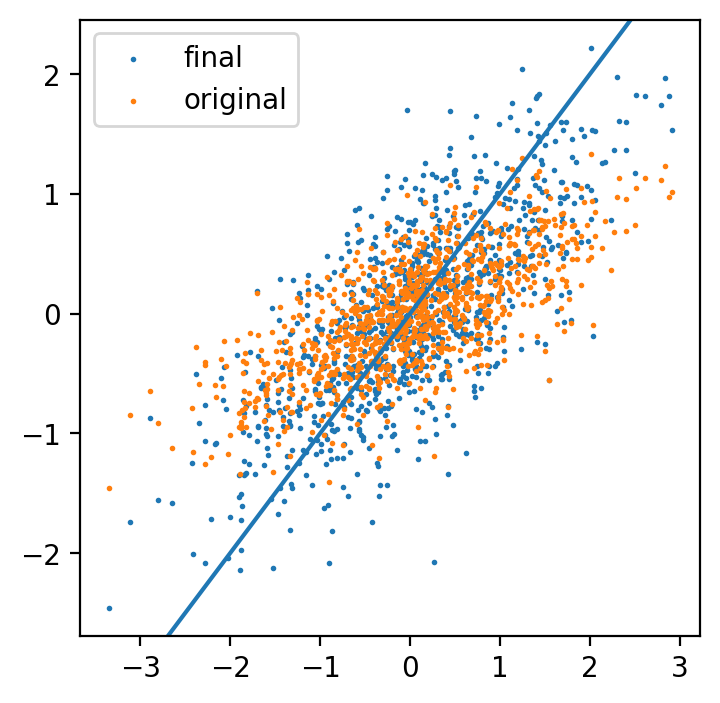

In [15]:
plt.figure(figsize=(4, 4), dpi=200)
plt.scatter(x, np.array(mean_post_list_final)[:, 0], s=1, label='final')
plt.scatter(x, np.array(mean_post_list_0)[:, 0], s=1, label='original')
plt.axline([0, 0], [1, 1])
plt.legend()

np.std(np.array(mean_post_list_final)[:, 0] - x), np.std(np.array(mean_post_list_0)[:, 0] - x)

## Use MAP

Can not work, The distribution of the MAP estimate is not the MAP estimate of the distribution.

极大后验估计的分布，不是分布的极大后验估计

In [39]:
def one_step(x_obs, y_obs, mean, cov, N=100):
    mean_post_list = []
    cov_post_list = []

    for x_obs_i, y_obs_i in zip(x_obs, y_obs):
        _mean, _cov = get_posterior(x_obs_i, y_obs_i, mean, cov)
        mean_post_list.append(_mean)
        cov_post_list.append(_cov)

    mean_post_arr = np.array(mean_post_list)
    
    x_post_all = mean_post_arr[:, 0]
    y_post_all = mean_post_arr[:, 1]

    mean_new = np.mean([x_post_all, y_post_all], axis=1)
    cov_new = np.cov([x_post_all, y_post_all])

    return mean_new, cov_new

In [44]:
mean_0 = [0, 0]
cov_0 = [[0.5, 0], [0, 0.5]]

_mean = mean_0
_cov = cov_0
for i in range(20):
    _mean, _cov = one_step(x_obs, y_obs, _mean, _cov, N=100)
    if i % 5 == 0:
        print('-----')
        print(i)
        print(_mean)
        print(_cov)

print('-----')
print('final')
print(_mean)
print(_cov)

-----
0
[-0.02363533 -0.01880915]
[[0.21727616 0.05606597]
 [0.05606597 0.21827249]]
-----
5
[-0.03772215 -0.03137232]
[[4.31362081e-11 4.35211900e-11]
 [4.35211900e-11 4.39096077e-11]]
-----
10
[-0.03772215 -0.03137232]
[[0. 0.]
 [0. 0.]]
-----
15
[-0.03772215 -0.03137232]
[[0. 0.]
 [0. 0.]]
-----
final
[-0.03772215 -0.03137232]
[[0. 0.]
 [0. 0.]]


## Reweight

$$
q_{n+1}(x, y|x_{obs}, y_{obs}) = q_{n}(x, y|x_{obs}, y_{obs}) \frac{q_{n+1}(x, y)}{q_{n}(x, y)} \frac{q_{n}(x_{obs}, y_{obs})}{q_{n+1}(x_{obs}, y_{obs})}
$$

In [130]:
N = 1000

mean_post_list = []
cov_post_list = []

mean_0 = np.array([0, 0])
cov_0 = np.array([[0.5, 0], [0, 0.5]])

for x_obs_i, y_obs_i in zip(x_obs, y_obs):
    _mean, _cov = get_posterior(x_obs_i, y_obs_i, mean_0, cov_0)
    mean_post_list.append(_mean)
    cov_post_list.append(_cov)

x_post_all = np.zeros((x.shape[0], N))
y_post_all = np.zeros((y.shape[0], N))
w_0 = np.ones((y.shape[0], N))

for i, (_mean, _cov) in enumerate(zip(mean_post_list, cov_post_list)):
    x_post_all[i], y_post_all[i] = multivariate_normal(mean=_mean,
                                                    cov=_cov).rvs(N).T

x_post_all_flat = x_post_all.flatten()
y_post_all_flat = y_post_all.flatten()

In [131]:
def one_step_reweight(x_sample, y_sample, w_0, mean_0, cov_0):
    x_sample_flat = x_sample.flatten()
    y_sample_flat = y_sample.flatten()
    w_flat = w_0.flatten()

    mean_new = np.average([x_sample_flat, y_sample_flat], axis=1, weights=w_flat)
    cov_new = np.cov([x_sample_flat, y_sample_flat], aweights=w_flat)

    q_new = multivariate_normal(mean=mean_new, cov=cov_new).pdf(
        np.transpose([x_sample_flat, y_sample_flat]))
    q_old = multivariate_normal(mean=mean_0, cov=cov_0).pdf(
        np.transpose([x_sample_flat, y_sample_flat]))

    w_new = w_0 * q_new.reshape(x_sample.shape)/q_old.reshape(x_sample.shape)
    w_new = w_new/w_new.sum(axis=1).reshape(-1, 1)
    
    return w_new, mean_new, cov_new

In [133]:
mean_0 = [0, 0]
cov_0 = [[0.5, 0], [0, 0.5]]
w_0 = np.ones((y.shape[0], N))

_mean = mean_0
_cov = cov_0
_w = w_0
for i in range(30):
    _w, _mean, _cov = one_step_reweight(x_post_all, y_post_all, _w, _mean, _cov)
    if i % 5 == 0:
        print('-----')
        print(i)
        print(_mean)
        print(_cov)

print('-----')
print('final')
print(_mean)
print(_cov)

-----
0
[-0.02312829 -0.01917101]
[[0.55205848 0.05669399]
 [0.05669399 0.55177398]]
-----
5
[-0.06274499 -0.05389317]
[[0.83814824 0.35482925]
 [0.35482925 0.83113851]]
-----
10
[-0.06197803 -0.05327623]
[[0.91149341 0.43182417]
 [0.43182417 0.89678097]]
-----
15
[-0.06168331 -0.05310709]
[[0.91656913 0.43946187]
 [0.43946187 0.89905862]]
-----
20
[-0.06165381 -0.05311833]
[[0.91626878 0.44091072]
 [0.44091072 0.89788805]]
-----
25
[-0.06165124 -0.05312914]
[[0.91580325 0.44153775]
 [0.44153775 0.89716582]]
-----
final
[-0.06165163 -0.05313365]
[[0.91554172 0.44182479]
 [0.44182479 0.89684415]]
